# Score-matching informed KDE

In [2]:
%pip install memory_profiler
%pip install tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('..')

import torch
import torch.optim as optim
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
import lib.toy_data as toy_data
import numpy as np
import argparse
import pandas as pd
from pandas.plotting import scatter_matrix as pdsm
import function_cpu as LearnCholesky
import torch.multiprocessing as mp

from memory_profiler import profile
from tqdm import trange
import time
import gc
# git testing

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available")
else:
    device = torch.device('cpu')
    print("GPU is not available")
print(device)

GPU is not available
cpu


### Parsing for scripts

In [4]:
parser = argparse.ArgumentParser(' ')
parser.add_argument('--data', choices=['swissroll', '8gaussians', 'pinwheel', 'circles', 'moons', '2spirals', 'checkerboard', 'rings','swissroll_6D_xy1', 'cifar10'], type = str,default = '2spirals')
parser.add_argument('--depth',help = 'number of hidden layers of score network',type =int, default = 5)
parser.add_argument('--hiddenunits',help = 'number of nodes per hidden layer', type = int, default = 64)
parser.add_argument('--niters',type = int, default = 50)
parser.add_argument('--batch_size', type = int,default = 4)
parser.add_argument('--lr',type = float, default = 2e-3) 
parser.add_argument('--save',type = str,default = 'cifar10_experiments/')
parser.add_argument('--train_kernel_size',type = int, default = 10)
parser.add_argument('--train_samples_size',type = int, default = 500)
parser.add_argument('--test_samples_size',type = int, default = 5)
args = parser.parse_args('')

In [5]:
train_kernel_size = args.train_kernel_size
train_samples_size = args.train_samples_size
test_samples_size = args.test_samples_size
dataset = args.data 
save_directory = args.save + 'test'+'/'

print('save_directory',save_directory)

if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    print('Created directory ' + save_directory)

save_directory cifar10_experiments/test/


### Precision matrix model

In [6]:
## Cholesky factor model
def construct_factor_model(dim:int, depth:int, hidden_units:int):
    '''
    Initializes neural network that models the Cholesky factor of the precision matrix # For nD examples (in theory)
    '''
    chain = []
    chain.append(nn.Linear(dim,int(hidden_units),bias =True)) 
    chain.append(nn.GELU())

    for _ in range(depth-1):
        chain.append(nn.Linear(int(hidden_units),int(hidden_units),bias = True))
        chain.append(nn.GELU())
    chain.append(nn.Linear(int(hidden_units),int(dim*(dim+1)/2),bias = True)) 

    return nn.Sequential(*chain)   

### Helper functions

In [7]:
@profile
def evaluate_model(factornet, kernel_centers, num_test_sample):
    '''
    Evaluate the model by computing the average total loss over 10 batch of testing samples
    '''
    total_loss_sum = 0
    device = kernel_centers.device
    for i in range(10):
        p_samples = toy_data.inf_train_gen(dataset,batch_size = num_test_sample)
        testing_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)
        total_loss = LearnCholesky.score_implicit_matching(factornet,testing_samples,kernel_centers)
        total_loss_sum += total_loss.item()
         # Free up memory
        del p_samples, testing_samples, total_loss
        #gc.collect() #only if using CPU
        torch.cuda.empty_cache()  # Only if using GPU
    average_total_loss = total_loss_sum / 10
    return average_total_loss

def save_training_slice_cov(factornet, means, epoch, lr, batch_size, loss_value, save):
    '''
    Save the training slice of the NN
    '''
    if save is not None:
        torch.save(factornet.state_dict(), save + 'epoch' + str(epoch) + 'model_weights.pth')

    """ OLD CODE
    if means.shape[1] != 2:
        return
    plot_axis = means.max().item() * 1.1
    device = means.device
    # Create x as a NumPy array
    x_np = np.meshgrid(np.linspace(-plot_axis, plot_axis, 200), np.linspace(-plot_axis, plot_axis, 200))
    x_np = np.stack(x_np, axis=-1).reshape(-1, 2)

    x = torch.tensor(x_np, dtype=torch.float32, device=device)
    data_dim = x.shape[1]
    precisions = LearnCholesky.vectors_to_precision(factornet(means),data_dim)
    density = LearnCholesky.mog_density(x, means, precisions)

    density = density.reshape(200, 200).T

    # Create a figure
    fig = plt.figure(figsize=(8, 4))
    plt.clf()
    
    plt.subplot(1, 2, 1) 
    plt.contourf(np.linspace(-plot_axis, plot_axis, 200), np.linspace(-plot_axis, plot_axis, 200), density.detach().cpu().numpy(), cmap='viridis')
    plt.axis('square')
    plt.colorbar()     
    
    plt.subplot(1, 2, 2) 
    plt.contourf(np.linspace(-plot_axis, plot_axis, 200), np.linspace(-plot_axis, plot_axis, 200), density.detach().cpu().numpy(), cmap='viridis')
    # Plot the centers
    num_components = torch.min(torch.tensor([means.shape[0], 400]))
    plot_centers = means[:num_components].detach().cpu().numpy()
    plt.scatter(plot_centers[:,1], plot_centers[:,0], s=0.2, c='r')
    plt.axis('square')
    # plt.colorbar()    
    plt.title(f'Epoch: {epoch}, Loss: {loss_value:.3e}')
             
    plt.tight_layout()  # Improve subplot spacing

    # Save the figure
    lr_str = f'{lr:.2e}'
    if save is not None:
        plt.savefig(f'{save}batch_size_{batch_size}lr_{lr_str}_epoch_{epoch}.png')

    plt.close(fig)
    """
    

### Initialize score network

data_dim 2


array([[<Axes: xlabel='0', ylabel='0'>, <Axes: xlabel='1', ylabel='0'>],
       [<Axes: xlabel='0', ylabel='1'>, <Axes: xlabel='1', ylabel='1'>]],
      dtype=object)

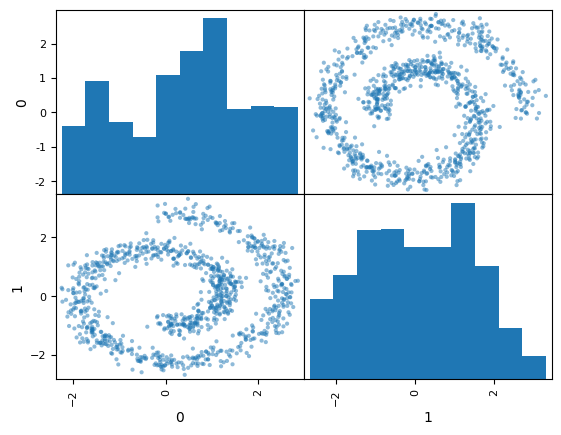

In [8]:
# check the dataset
dataset = args.data
dataset = 'swissroll'
# dataset = 'swissroll_6D_xy1'
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)
data_dim = means.shape[1]
print('data_dim',data_dim)

blah = pd.DataFrame(means)
pdsm(blah)

## Initialize Data using CIFAR-10


In [9]:
# check the dataset
dataset = args.data
dataset = 'cifar10'
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32)
data_dim = means.shape[1]
# dataset = 'swissroll_6D_xy1'
""""" # not used anymore since our data is pictures
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)
data_dim = means.shape[1]
print('data_dim',data_dim)

blah = pd.DataFrame(means)
pdsm(blah)
"""


tensor(-1.) tensor(1.)


/var/tmp/ipykernel_447013/310266888.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32)


'"" # not used anymore since our data is pictures\nmeans  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)\ndata_dim = means.shape[1]\nprint(\'data_dim\',data_dim)\n\nblah = pd.DataFrame(means)\npdsm(blah)\n'

In [37]:
depth = args.depth
hidden_units = args.hiddenunits
factornet = construct_factor_model(data_dim, depth, hidden_units).to(device).to(dtype = torch.float32)

lr = args.lr
optimizer = optim.Adam(factornet.parameters(), lr=args.lr)

p_samples = toy_data.inf_train_gen(dataset,batch_size = train_samples_size)
training_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)
centers  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32).to(device)

torch.save(centers, save_directory + str(epochs) + 'epochs' + str(train_kernel_size) + 'centers.pt')

epochs = args.niters
batch_size = args.batch_size

# Training the score network
loss = evaluate_model(factornet, centers, test_samples_size)
formatted_loss = f'{loss:.3e}'  # Format the average with up to 1e-3 precision
print(f'Before train, Average total_loss: {formatted_loss}')

tensor(-1.) tensor(1.)


/var/tmp/ipykernel_447013/367874541.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)


tensor(-1.) tensor(1.)
ERROR: Could not find file /var/tmp/ipykernel_447013/2379803456.py


/var/tmp/ipykernel_447013/367874541.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32).to(device)


tensor(-1.) tensor(1.)
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-1.) tensor(1.)
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-1.) tensor(1.)
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-1.) tensor(1.)
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-1.) tensor(0.9843)
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-0.9451) tensor(1.)
precision

Exception ignored in: <function _releaseLock at 0x7ff7466171c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
  File "/opt/conda/lib/python3.10/site-packages/memory_profiler.py", line 791, in trace_memory_usage
    def trace_memory_usage(self, frame, event, arg):
KeyboardInterrupt: 


tensor(-1.) tensor(1.)
precisions requires grad: True
samples requires grad: False
centers requires grad: True


KeyboardInterrupt: 

In [11]:
#@profile
def opt_check(factornet, samples, centers):
    loss = LearnCholesky.score_implicit_matching(factornet,samples,centers)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

# Use trange instead of range to get tqdm progress bar
for step in trange(epochs, desc="Training"):
    print(f"Step {step} started")
    randind = torch.randint(0, train_samples_size, [batch_size,])
    samples = training_samples[randind, :]
    loss_value = opt_check(factornet, samples, centers)

    if step % 4000 == 0:
        print(f'Step: {step}, Loss value: {loss_value:.3e}')
    
    if step % 20000 == 0:
        loss0 = evaluate_model(factornet, centers, test_samples_size)
        save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)
        
    if step < epochs - 1:
        del samples
        gc.collect()
        torch.cuda.empty_cache()


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Step 0 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
Step: 0, Loss value: 1.187e+05
ERROR: Could not find file /var/tmp/ipykernel_447013/2379803456.py
tensor(-0.9843) tensor(1.)


/var/tmp/ipykernel_447013/2379803456.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testing_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)


precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-0.9294) tensor(1.)
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-1.) tensor(1.)
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-1.) tensor(1.)
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-0.9922) tensor(0.9922)
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-1.) tensor(1.)
precisions requires grad: Tr

Training:   2%|▏         | 1/50 [01:09<56:38, 69.35s/it]

Step 1 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:   4%|▍         | 2/50 [01:21<28:40, 35.84s/it]

Step 2 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:   6%|▌         | 3/50 [01:34<19:40, 25.12s/it]

Step 3 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:   8%|▊         | 4/50 [01:47<15:36, 20.36s/it]

Step 4 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  10%|█         | 5/50 [01:59<13:06, 17.48s/it]

Step 5 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  12%|█▏        | 6/50 [02:11<11:32, 15.73s/it]

Step 6 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  14%|█▍        | 7/50 [04:55<46:02, 64.24s/it]

Step 7 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  16%|█▌        | 8/50 [05:08<33:24, 47.72s/it]

Step 8 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  18%|█▊        | 9/50 [05:20<25:03, 36.66s/it]

Step 9 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  20%|██        | 10/50 [05:33<19:26, 29.16s/it]

Step 10 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  22%|██▏       | 11/50 [05:45<15:42, 24.16s/it]

Step 11 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  24%|██▍       | 12/50 [05:58<13:03, 20.62s/it]

Step 12 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  26%|██▌       | 13/50 [06:10<11:10, 18.13s/it]

Step 13 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  28%|██▊       | 14/50 [06:23<09:50, 16.40s/it]

Step 14 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  30%|███       | 15/50 [06:35<08:51, 15.18s/it]

Step 15 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  32%|███▏      | 16/50 [06:48<08:13, 14.50s/it]

Step 16 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  34%|███▍      | 17/50 [07:00<07:36, 13.85s/it]

Step 17 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  36%|███▌      | 18/50 [07:13<07:09, 13.42s/it]

Step 18 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  38%|███▊      | 19/50 [07:25<06:47, 13.15s/it]

Step 19 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  40%|████      | 20/50 [07:38<06:28, 12.94s/it]

Step 20 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  42%|████▏     | 21/50 [07:50<06:11, 12.79s/it]

Step 21 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  44%|████▍     | 22/50 [08:03<05:54, 12.66s/it]

Step 22 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  46%|████▌     | 23/50 [08:15<05:39, 12.56s/it]

Step 23 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  48%|████▊     | 24/50 [08:27<05:24, 12.49s/it]

Step 24 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  50%|█████     | 25/50 [08:40<05:15, 12.64s/it]

Step 25 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  52%|█████▏    | 26/50 [08:52<05:00, 12.53s/it]

Step 26 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  54%|█████▍    | 27/50 [09:05<04:47, 12.49s/it]

Step 27 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  56%|█████▌    | 28/50 [09:17<04:33, 12.44s/it]

Step 28 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  58%|█████▊    | 29/50 [09:29<04:20, 12.40s/it]

Step 29 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  60%|██████    | 30/50 [09:42<04:09, 12.47s/it]

Step 30 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  62%|██████▏   | 31/50 [09:54<03:56, 12.45s/it]

Step 31 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  64%|██████▍   | 32/50 [10:07<03:43, 12.42s/it]

Step 32 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  66%|██████▌   | 33/50 [10:19<03:32, 12.47s/it]

Step 33 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  68%|██████▊   | 34/50 [10:32<03:18, 12.43s/it]

Step 34 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  70%|███████   | 35/50 [10:45<03:08, 12.55s/it]

Step 35 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  72%|███████▏  | 36/50 [10:57<02:54, 12.47s/it]

Step 36 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  74%|███████▍  | 37/50 [11:09<02:41, 12.43s/it]

Step 37 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  76%|███████▌  | 38/50 [11:22<02:29, 12.42s/it]

Step 38 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  78%|███████▊  | 39/50 [11:34<02:16, 12.42s/it]

Step 39 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  80%|████████  | 40/50 [11:47<02:05, 12.58s/it]

Step 40 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  82%|████████▏ | 41/50 [11:59<01:52, 12.50s/it]

Step 41 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  84%|████████▍ | 42/50 [12:12<01:39, 12.49s/it]

Step 42 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  86%|████████▌ | 43/50 [12:24<01:27, 12.49s/it]

Step 43 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  88%|████████▊ | 44/50 [12:37<01:14, 12.48s/it]

Step 44 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  90%|█████████ | 45/50 [12:49<01:02, 12.56s/it]

Step 45 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  92%|█████████▏| 46/50 [13:02<00:49, 12.49s/it]

Step 46 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  94%|█████████▍| 47/50 [13:14<00:37, 12.45s/it]

Step 47 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  96%|█████████▌| 48/50 [13:27<00:24, 12.43s/it]

Step 48 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training:  98%|█████████▊| 49/50 [13:39<00:12, 12.45s/it]

Step 49 started
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True


Training: 100%|██████████| 50/50 [13:51<00:00, 16.64s/it]


In [13]:
loss = evaluate_model(factornet, centers, test_samples_size)    
save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)
formatted_loss = f'{loss:.3e}'  # Format the average with up to 1e-3 precision
print(f'After train, Average total_loss: {formatted_loss}')

ERROR: Could not find file /var/tmp/ipykernel_447013/2379803456.py
tensor(-0.9686) tensor(1.)


/var/tmp/ipykernel_447013/2379803456.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testing_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)


precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-1.) tensor(1.)
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-1.) tensor(1.)
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-1.) tensor(1.)
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-1.) tensor(1.)
precisions requires grad: True
samples requires grad: False
centers requires grad: True
laplacian_over_density requires grad: True
gradient_eval_log requires grad: True
tensor(-1.) tensor(0.9922)
precisions requires grad: True
sampl

In [10]:

import time

for step in range(epochs):
    start = time.time()
    # samples_toydata
    randind = torch.randint(0,train_samples_size,[batch_size,])
    samples = training_samples[randind,:]
    loss_value = opt_check(factornet, samples, centers)
    """
    loss = LearnCholesky.score_implicit_matching(factornet,samples,centers)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    """
   
    
    if not step % 4000:
        #loss_value = loss.item()
        print(f'Step: {step}, Loss value: {loss_value:.3e}')

    if not step % 20000:
        loss0 = evaluate_model(factornet, centers, test_samples_size)
        save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)
    if step < epochs - 1:
         # Free up memory
        del samples # del loss
        gc.collect()
        torch.cuda.empty_cache()
    print("Elapsed time:", time.time() - start)
    
loss = evaluate_model(factornet, centers, test_samples_size)    
save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)
formatted_loss = f'{loss:.3e}'  # Format the average with up to 1e-3 precision
print(f'After train, Average total_loss: {formatted_loss}')

ERROR: Could not find file /var/tmp/ipykernel_174720/1267574142.py


/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    16   3825.4 MiB   3825.4 MiB           1   @profile
    17                                         def vectors_to_precision(vectors,dim):
    18                                             """
    19                                             Maps an array of 1xdim vectors into Cholesky factors and returns an array of precision matrices.
    20                                             
    21                                             Args:
    22                                             vectors (torch.Tensor): A tensor of shape (batch_size, 1, dim), where each 1xdim tensor represents the
    23                                                                     lower triangular part of the Cholesky factor.
    24                                             
    25                                             Returns:
    26                                      

/home/jupyter/wpo_distill/function_cpu.py:258: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast('cpu', dtype=torch.bfloat16):
/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   188  11152.4 MiB  11152.4 MiB           1   @profile
   189                                         def laplacian_mog_density_div_density(x, means, precisions):
   190  11152.4 MiB      0.0 MiB           1       x = x.unsqueeze(1)  # Shape: (batch_size, 1, 2)
   191  11152.4 MiB      0.0 MiB           1       batch_size, num_components = x.size(0), means.size(0)
   192                                         
   193                                             # Create a batch of Multivariate Normal distributions for each component
   194  21955.3 MiB  10802.9 MiB           1       mvns = MultivariateNormal(loc=means, precision_matrix=precisions)
   195                                         
   196                                             # Calculate the log probabilities for each component
   197  21969.8 MiB     14.5 MiB           1       log_probs = mvns.log_prob

/var/tmp/ipykernel_174720/4110140829.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testing_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)


Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    16   7563.0 MiB   7563.0 MiB           1   @profile
    17                                         def vectors_to_precision(vectors,dim):
    18                                             """
    19                                             Maps an array of 1xdim vectors into Cholesky factors and returns an array of precision matrices.
    20                                             
    21                                             Args:
    22                                             vectors (torch.Tensor): A tensor of shape (batch_size, 1, dim), where each 1xdim tensor represents the
    23                                                                     lower triangular part of the Cholesky factor.
    24                                             
    25                                             Returns:
    26                                      

KeyboardInterrupt: 

In [35]:
# sample from trained model
# and plot density
#file /wpo_distill/cifar10_experiments/test/epoch499model_weights.pth
#factornet.load_state_dict(torch.load('wpo_distill/cifar10_experiments/test/epoch499model_weights.pth'))
print(os.path.exists("/home/jupyter/wpo_distill/cifar10_experiments/test/epoch499model_weights.pth"))
print("Current working dir:", os.getcwd())
model = construct_factor_model(data_dim, depth, hidden_units).to(device).to(dtype = torch.float32)
model.load_state_dict(torch.load("/home/jupyter/wpo_distill/cifar10_experiments/test/epoch499model_weights.pth"))

with torch.no_grad():
        
    precisions = LearnCholesky.vectors_to_precision(model(centers),data_dim)

    LearnCholesky.plot_images(centers, precisions, epoch = 49, plot_number=10, save_path=save_directory + 'samples')

""" I think this will not work for general (centers needs to be same as before to plot properly)
randind = torch.randint(0,1000,[1000,])
centers = means[randind,:].to(device)
precisions = LearnCholesky.vectors_to_precision(factornet(centers),data_dim)

LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 0, dim2 = 1,save_path=save_directory + 'samples.png')
LearnCholesky.plot_density_2d_marg(centers,factornet,dim1 = 0, dim2 = 1, save_path=save_directory + 'density.png')
"""

True
Current working dir: /home/jupyter/wpo_distill


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.691046..15.402475].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.706252..12.815369].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.633032..13.250306].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-16.568491..16.274464].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11.301103..11.333479].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-13.891276..13.010072].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14.05074

" I think this will not work for general (centers needs to be same as before to plot properly)\nrandind = torch.randint(0,1000,[1000,])\ncenters = means[randind,:].to(device)\nprecisions = LearnCholesky.vectors_to_precision(factornet(centers),data_dim)\n\nLearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 0, dim2 = 1,save_path=save_directory + 'samples.png')\nLearnCholesky.plot_density_2d_marg(centers,factornet,dim1 = 0, dim2 = 1, save_path=save_directory + 'density.png')\n"

In [ ]:
# LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 2, dim2 = 3, save_path=save_directory + 'samples.png')
# LearnCholesky.plot_density_2d_marg(centers,factornet, dim1 = 2, dim2 = 3, save_path=save_directory + 'density.png')
# LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 4, dim2 = 5,  save_path=save_directory + 'samples.png')
# LearnCholesky.plot_density_2d_marg(centers,factornet, dim1 = 4, dim2 = 5,save_path=save_directory + 'density.png')